In [ ]:
import os
import sys
sys.path.insert(0,"../")
from models.unet import UNetDiffusion, UNet_diffusion_normal, UNet_diffusion_mixednormal, UNet_diffusion_mvnormal
from data.datasets import WeatherBench
import torch
from models.diffusion import generate_diffusion_samples_low_dimensional
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmcrameri
from cmap import Colormap
import scienceplots

device = "cuda"

plt.rcParams['image.cmap'] = 'cmc.vik'

In [2]:
test_dataset = WeatherBench(
    var="test",
    downscaling_factor=1,
    normalize=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=3,
    shuffle=False,
    num_workers=0,
)

target_dim, input_dim = (
    (1, *test_dataset.get_dimensions()),
    (3, *test_dataset.get_dimensions()),
)
lat_lon, t= test_dataset.get_grid()
lat,lon = lat_lon

# Index of input t2m
t2m = 1

In [3]:
cfg_scale = 0
x_T_sampling_method="standard"
n_timesteps = 50
n_samples = 5

In [4]:
for target, input in test_loader:
    input = input.to(device)
    target = target.to(device)
    break

# Single plot in residual space

In [5]:
ticksize = 25
legendsize = 29
axissize = 27
titlesize = 30
plt.style.use(["science"])

b = 0

In [46]:
def plot(pred, target, name, b=0, s=0):
    fig, axs = plt.subplots(1, 4, figsize=(16, 3), sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()}, layout = "constrained")
    pred = pred.squeeze(1).cpu()
    target = target.squeeze(1).cpu()
    error_cmap = Colormap('seaborn:icefire').to_mpl()

    vmin_truth = target[b].min()
    vmax_truth =target[b].max()

    cbs = []
    shrink = 0.77
    # Truth Residual
    im1 = axs[0].pcolormesh(lon, lat, target[b], shading = "nearest", rasterized = True, vmin = vmin_truth, vmax = vmax_truth)
    cbs.append(fig.colorbar(im1, ax=axs[0], pad = 0.03, shrink = shrink))
    axs[0].set_title("Ground truth", size = titlesize)

    # Trajectory
    im2 = axs[2].pcolormesh(lon, lat, (pred[b].mean(dim = -1).numpy()-target[b].numpy())**2, shading = "nearest",  rasterized = True, cmap = error_cmap, vmax = 0.32)
    cbs.append(fig.colorbar(im2, ax=axs[2], pad = 0.03, shrink = shrink))
    axs[2].set_title("Squared error", size = titlesize)

    im3 = axs[1].pcolormesh(lon, lat, pred[b].mean(dim = -1).numpy(), shading = "nearest", rasterized = True, vmin = vmin_truth, vmax = vmax_truth)
    cbs.append(fig.colorbar(im3, ax=axs[1], pad = 0.03, shrink = shrink))
    axs[1].set_title("Mean prediction", size = titlesize)

    im4 = axs[3].pcolormesh(lon, lat, pred[b].std(dim = -1).cpu().numpy(),shading = "nearest", cmap = "cividis", rasterized = True, vmax = 0.32)
    cbs.append(fig.colorbar(im4, ax=axs[3], pad = 0.03, shrink = shrink))
    axs[3].set_title("Standard deviation", size = titlesize)

    for ax in axs:
        ax.set_extent([lon[0]-360, lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE, alpha = 0.8)

    for i in range(4):
        gl = axs[i].gridlines(draw_labels={"bottom":"x"}, dms=True, x_inline=False, y_inline=False)
        gl.xlines = False
        gl.ylines = False
        gl.xlabel_style = {'size':ticksize}

    for i in range(2):
        gl = axs[0].gridlines(draw_labels={"left":"y"}, dms=True, x_inline=False, y_inline=False)
        gl.xlines = False
        gl.ylines = False
        gl.ylabel_style = {'size':ticksize}


    for cb in cbs:
        cb.ax.tick_params(labelsize=legendsize)

    plt.savefig(f"plots/T2M_residual_{name}.pdf", bbox_inches = "tight")

In [47]:
idx = 500
target, input = test_dataset[idx]
target = target.unsqueeze(0).to(device)
input = input.unsqueeze(0).to(device)

n_samples = 50

## Deterministic

In [48]:
ckpt_path = "../results/T2M/deterministic/Datetime_20250905_082717_Loss_WeatherBench_UNet_diffusion_deterministic_T50_DDIM1.pt"
distributional_method = "deterministic"
beta_endpoints = (0.001, 0.35)

In [49]:
model =  UNetDiffusion(
            d=2,
            conditioning_dim=12,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim
        )
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)

/tmp/ipykernel_756629/272260365.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [50]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps = n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
    beta_endpoints=beta_endpoints
)

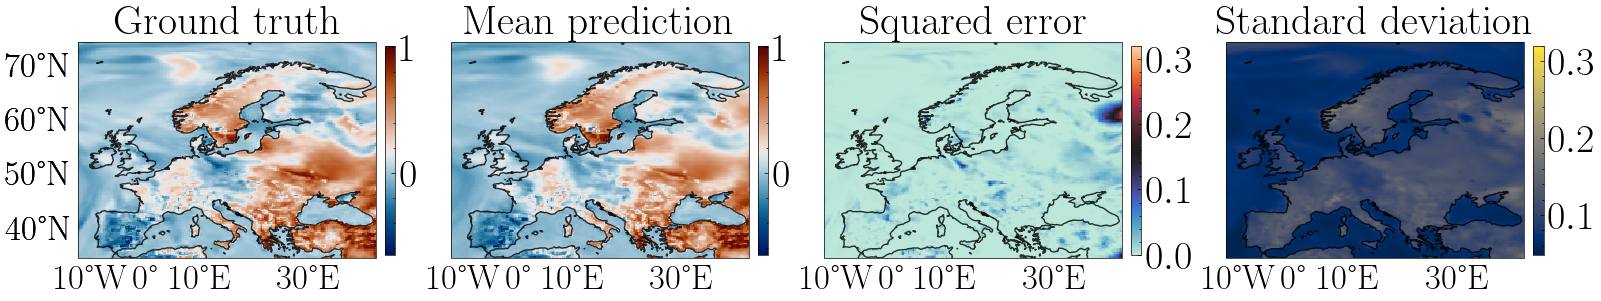

In [51]:
plot(pred, target, distributional_method, b=b, s=0)

## Normal

In [52]:
ckpt_path = "../results/T2M/normal/Datetime_20250908_031720_Loss_WeatherBench_UNet_diffusion_normal_T50_DDIM1.pt"
distributional_method = "normal"
beta_endpoints = (0.001, 0.2)

In [53]:
backbone =  UNetDiffusion(
            d=2,
            conditioning_dim=12,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim
        )

model = UNet_diffusion_normal(
    backbone=backbone,
    d=2,
    target_dim = 1,
)
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)


/tmp/ipykernel_756629/682118688.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [54]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
    beta_endpoints=beta_endpoints
)

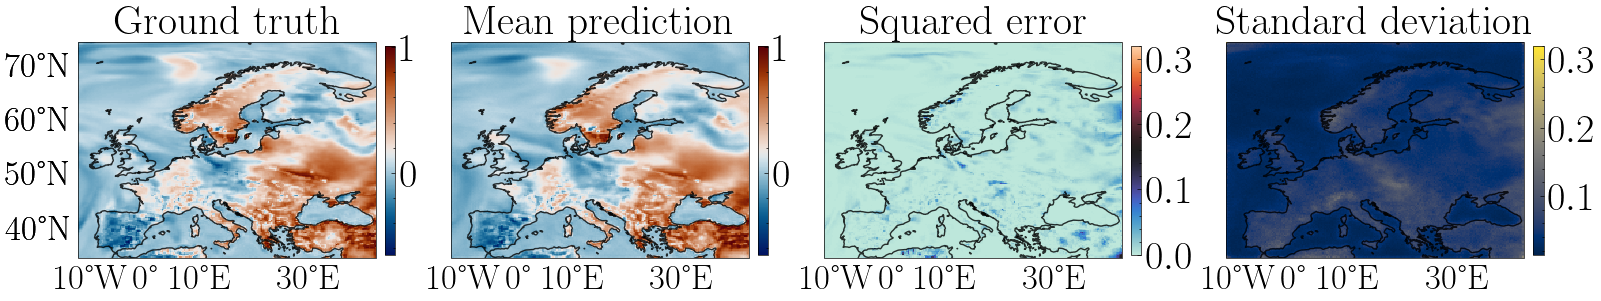

In [55]:
plot(pred, target, distributional_method, b=b, s=0)

# Full plots

In [96]:
def plot(pred, target, name, b=0, s=0):
    fig, axs = plt.subplots(1, 4, figsize=(16, 3), sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()}, layout = "constrained")
    pred = pred.squeeze(1).cpu()
    target = target.squeeze(1).cpu()
    error_cmap = Colormap('seaborn:icefire').to_mpl()

    vmin_truth = target[b].min()
    vmax_truth =target[b].max()

    cbs = []
    shrink = 0.69
    # Truth Residual
    im1 = axs[0].pcolormesh(lon, lat, target[b], shading = "nearest", rasterized = True, vmin = vmin_truth, vmax = vmax_truth)
    cbs.append(fig.colorbar(im1, ax=axs[0], pad = 0.03, shrink = shrink))
    axs[0].set_title("Ground truth", size = titlesize)

    # Trajectory
    im2 = axs[2].pcolormesh(lon, lat, (pred[b].mean(dim = -1).numpy()-target[b].numpy())**2, shading = "nearest",  rasterized = True, cmap = error_cmap, vmax = 0.62)
    cbs.append(fig.colorbar(im2, ax=axs[2], pad = 0.03, shrink =shrink))
    axs[2].set_title("Squared error", size = titlesize)

    im3 = axs[1].pcolormesh(lon, lat, pred[b].mean(dim = -1).numpy(), shading = "nearest", rasterized = True, vmin = vmin_truth, vmax = vmax_truth)
    cbs.append(fig.colorbar(im3, ax=axs[1], pad = 0.03, shrink =shrink))
    axs[1].set_title("Mean prediction", size = titlesize)

    im4 = axs[3].pcolormesh(lon, lat, pred[b].std(dim = -1).cpu().numpy(),shading = "nearest", cmap = "cividis", rasterized = True, vmax = 0.32)
    cbs.append(fig.colorbar(im4, ax=axs[3], pad = 0.03, shrink = shrink))
    axs[3].set_title("Standard deviation", size = titlesize)

    for ax in axs:
        ax.set_extent([lon[0]-360, lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE, alpha = 0.8)

    for i in range(4):
        gl = axs[i].gridlines(draw_labels={"bottom":"x"}, dms=True, x_inline=False, y_inline=False)
        gl.xlines = False
        gl.ylines = False
        gl.xlabel_style = {'size':ticksize}

    for i in range(2):
        gl = axs[0].gridlines(draw_labels={"left":"y"}, dms=True, x_inline=False, y_inline=False)
        gl.xlines = False
        gl.ylines = False
        gl.ylabel_style = {'size':ticksize}


    for cb in cbs:
        cb.ax.tick_params(labelsize=legendsize)

    plt.savefig(f"plots/T2M_residual_full_{name}.pdf", bbox_inches = "tight")

In [98]:
idx = 10
target, input = test_dataset[idx]
target = target.unsqueeze(0).to(device)
input = input.unsqueeze(0).to(device)

n_samples = 50

In [99]:
ticksize = 25
legendsize = 29
axissize = 27
titlesize = 30
plt.style.use(["science"])

b = 0

## Deterministic

In [100]:
ckpt_path = "../results/T2M/deterministic/Datetime_20250905_082717_Loss_WeatherBench_UNet_diffusion_deterministic_T50_DDIM1.pt"
distributional_method = "deterministic"
beta_endpoints = (0.001, 0.35)

In [101]:
model =  UNetDiffusion(
            d=2,
            conditioning_dim=12,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim
        )
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)

/tmp/ipykernel_756629/272260365.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [102]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps = n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
    beta_endpoints=beta_endpoints
)

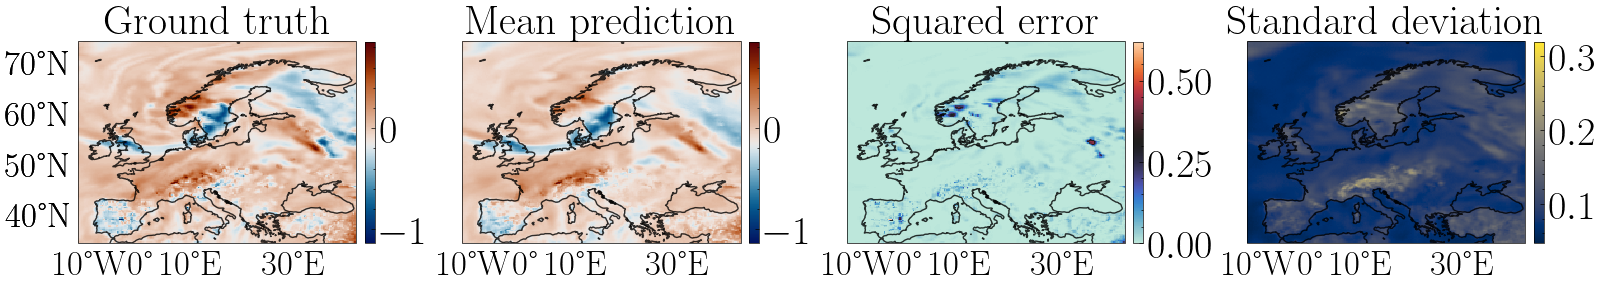

In [103]:
plot(pred, target, distributional_method, b=b, s=0)

## Normal

In [104]:
ckpt_path = "../results/T2M/normal/Datetime_20250908_031720_Loss_WeatherBench_UNet_diffusion_normal_T50_DDIM1.pt"
distributional_method = "normal"
beta_endpoints = (0.001, 0.2)

In [105]:
backbone =  UNetDiffusion(
            d=2,
            conditioning_dim=12,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim
        )

model = UNet_diffusion_normal(
    backbone=backbone,
    d=2,
    target_dim = 1,
)
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)


/tmp/ipykernel_756629/682118688.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [106]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
    beta_endpoints=beta_endpoints
)

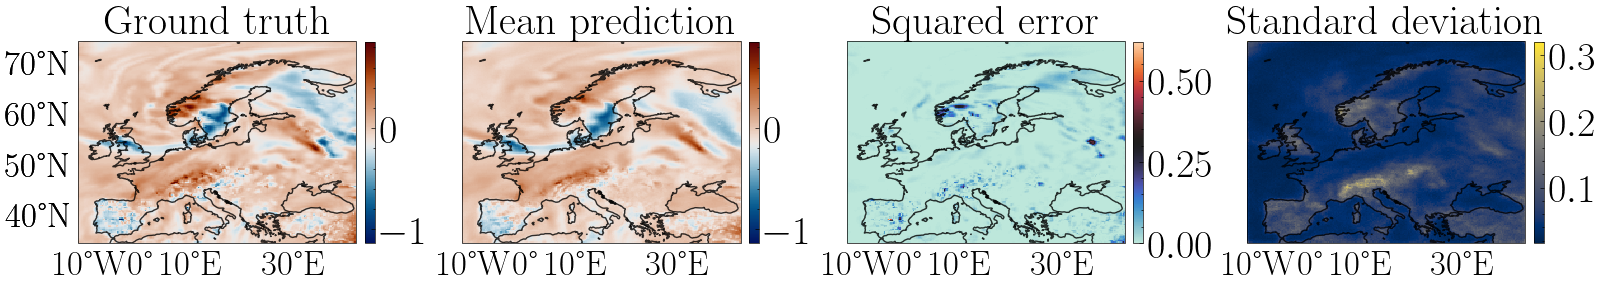

In [107]:
plot(pred, target, distributional_method, b=b, s=0)

## Mvnormal

In [108]:
ckpt_path = "../results/T2M/mvnormal/Datetime_20250911_114427_Loss_WeatherBench_UNet_diffusion_mvnormal_T50_DDIM1.pt"
distributional_method = "mvnormal"

In [109]:
backbone =  UNetDiffusion(
            d=2,
            conditioning_dim=12,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim
        )

model = UNet_diffusion_mvnormal(
    backbone=backbone,
    d=2,
    target_dim = 1,
    domain_dim = target_dim[1:],
    rank = 1,
    method = "lora"
)

model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)


/tmp/ipykernel_756629/3861496181.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [110]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
    beta_endpoints=(0.001, 0.35)
)

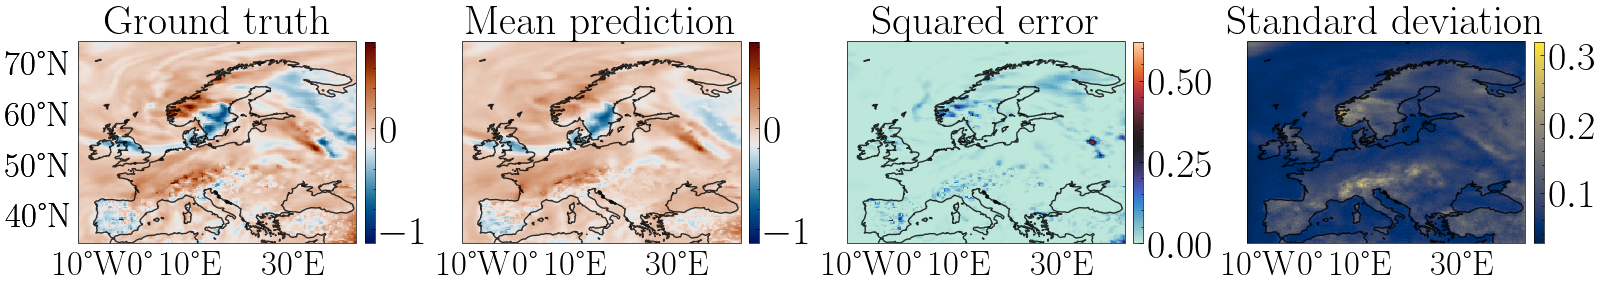

In [111]:
plot(pred, target, distributional_method, b=b, s=0)

## Mixednormal

In [112]:
ckpt_path = "../results/T2M/mixednormal/Datetime_20250909_124553_Loss_WeatherBench_UNet_diffusion_mixednormal_T50_DDIM1.pt"
distributional_method = "mixednormal"

In [113]:
backbone =  UNetDiffusion(
            d=2,
            conditioning_dim=12,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim
        )

model = UNet_diffusion_mixednormal(
    backbone=backbone,
    d=2,
    target_dim = 1,
    n_components=10,
)
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)


/tmp/ipykernel_756629/1937821052.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [114]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
    beta_endpoints=(0.001, 0.2)
)

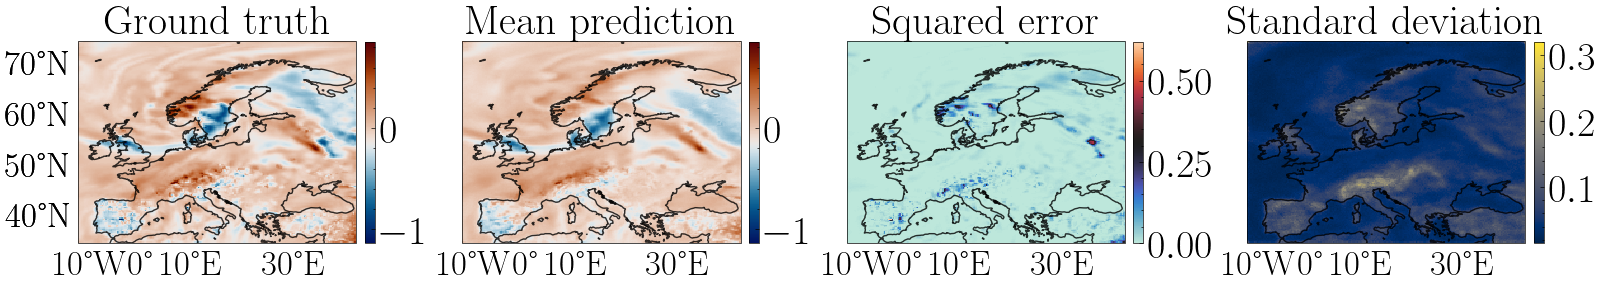

In [115]:
plot(pred, target, distributional_method, b=b, s=0)